# Сверточные нейронные сети (ноутбук)

> Знакомимся со сверточными нейронными сетями. Учимся решать задачу классификации изображений.

In [1]:
import warnings

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torchvision.transforms as T
from IPython.display import clear_output
from PIL import Image
from matplotlib import cm
from time import perf_counter
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST
from tqdm import tqdm

warnings.filterwarnings('ignore')

plt.rc('font', size=30)

## Загрузка изображения

Загрузим изображение из интернета, например, Питер Гриффина из одноименного мультсериала "Гриффины".

In [2]:
! wget "https://static.independent.co.uk/2021/10/29/14/newFile-8.jpg?width=1200" -O peter.jpg

--2022-10-11 13:17:53--  https://static.independent.co.uk/2021/10/29/14/newFile-8.jpg?width=1200
Resolving static.independent.co.uk (static.independent.co.uk)... 151.101.13.91, 2a04:4e42:3::347
Connecting to static.independent.co.uk (static.independent.co.uk)|151.101.13.91|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 112326 (110K) [image/jpeg]
Saving to: ‘peter.jpg’

peter.jpg           100%[===================>] 109,69K  --.-KB/s    in 0,08s   

2022-10-11 13:17:53 (1,36 MB/s) - ‘peter.jpg’ saved [112326/112326]



## Чтение изображения

In [3]:
img = Image.open('peter.jpg')

In [4]:
img.format

'JPEG'

In [5]:
img.size

(1200, 899)

In [6]:
img.mode

'RGB'

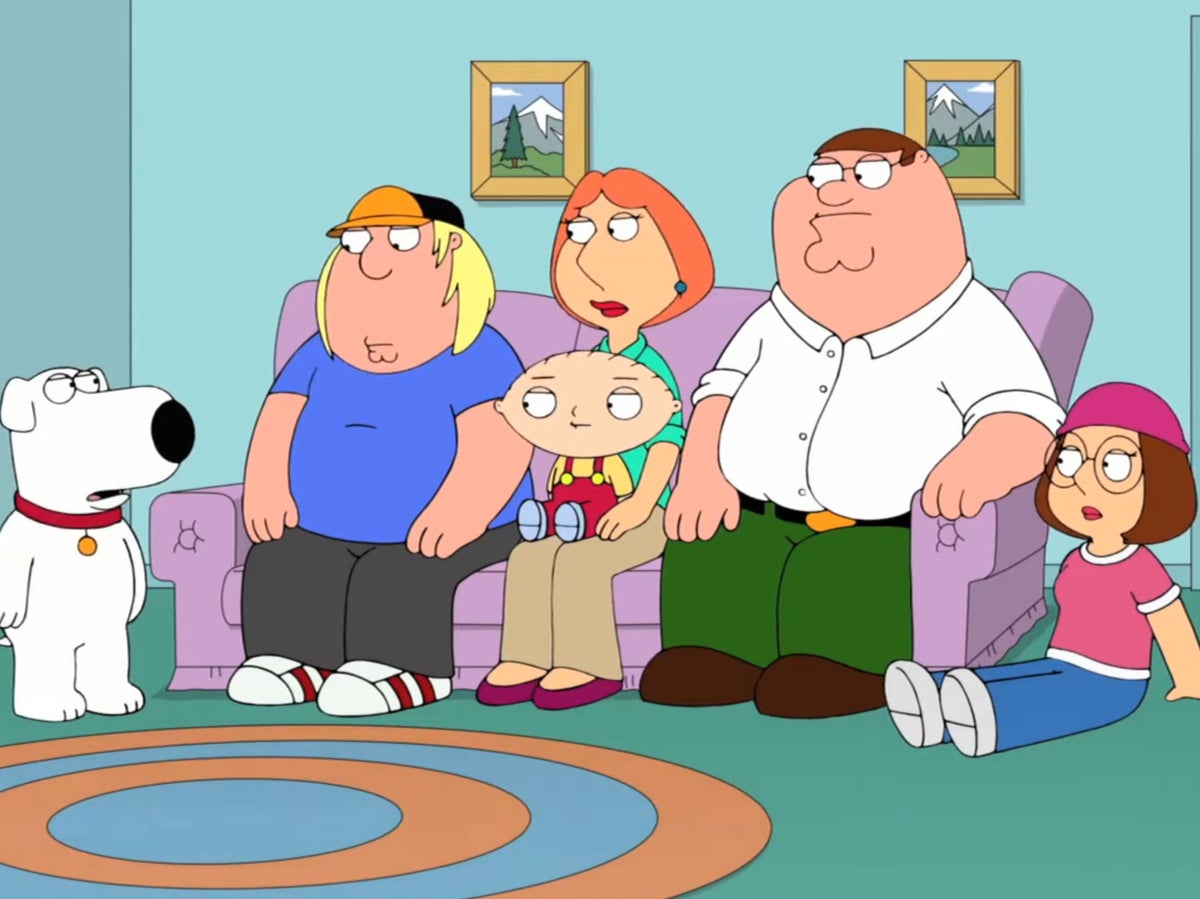

In [7]:
img

## Матричное представление

In [8]:
img_matrix = np.array(img)

In [9]:
img_matrix.shape

(899, 1200, 3)

In [10]:
img_matrix

array([[[142, 190, 194],
        [142, 190, 194],
        [142, 190, 194],
        ...,
        [157, 218, 219],
        [157, 218, 219],
        [157, 218, 219]],

       [[142, 190, 194],
        [142, 190, 194],
        [142, 190, 194],
        ...,
        [157, 218, 219],
        [157, 218, 219],
        [157, 218, 219]],

       [[142, 190, 194],
        [142, 190, 194],
        [142, 190, 194],
        ...,
        [158, 218, 219],
        [158, 218, 219],
        [158, 218, 219]],

       ...,

       [[121, 172, 201],
        [121, 172, 201],
        [121, 172, 201],
        ...,
        [ 91, 165, 152],
        [ 91, 165, 152],
        [ 91, 165, 152]],

       [[121, 172, 201],
        [121, 172, 201],
        [121, 172, 201],
        ...,
        [ 91, 165, 152],
        [ 91, 165, 152],
        [ 91, 165, 152]],

       [[121, 172, 201],
        [121, 172, 201],
        [121, 172, 201],
        ...,
        [ 91, 165, 152],
        [ 91, 165, 152],
        [ 91, 165, 152]]

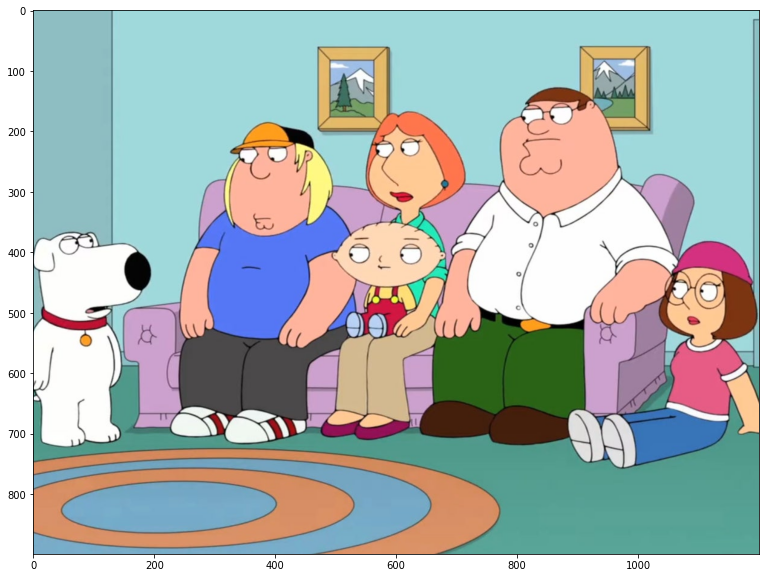

In [11]:
plt.figure(figsize=(20, 10))

plt.imshow(img_matrix)

plt.show()

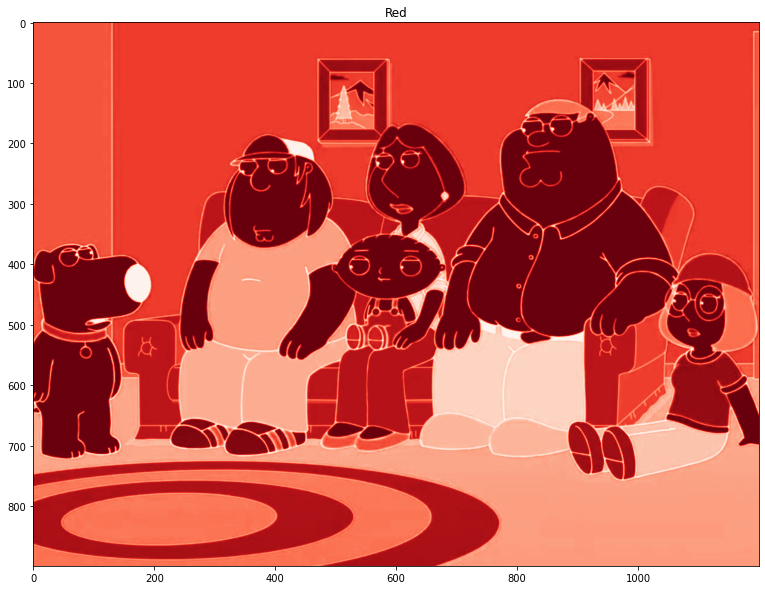

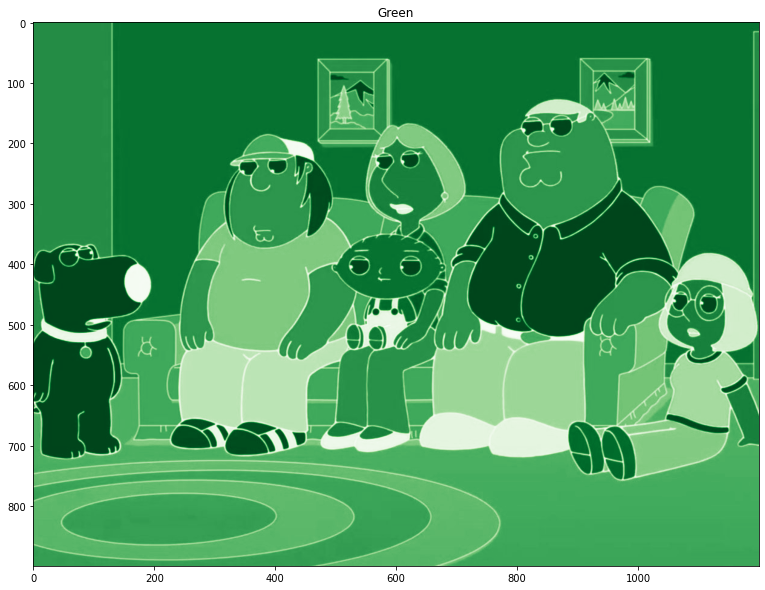

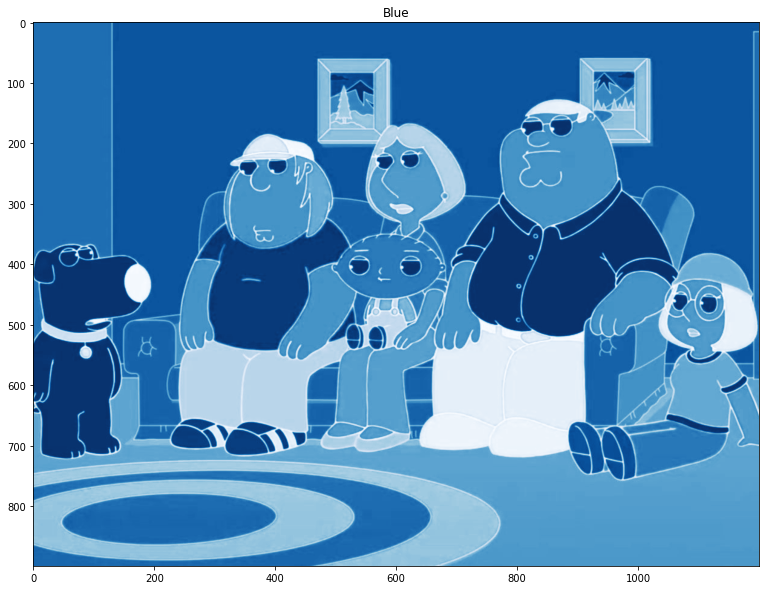

In [12]:
for i, (cmap, color) in enumerate(
    zip(
        [cm.Reds, cm.Greens, cm.Blues],
        ['Red', 'Green', 'Blue']
    )
):
    plt.figure(figsize=(20, 10))
    plt.imshow(img_matrix[:, :, i], cmap=cmap)
    plt.title(color)
    plt.show()

In [13]:
img_matrix[:, :, 0].min(), img_matrix[:, :, 0].max()

(0, 255)

## Свертка

Свертка в `PyTorch` представлена модулем `nn.Conv2d` со следующими параметрами:

- in_channels (int) – Количество каналов во входном изображении

- out_channels (int) – Количество каналов в выходном изображении

- kernel_size (int or tuple) – Размер ядра свертки

- stride (int or tuple, optional) – Страйд (шаг ядра свертки). По умолчанию: 1

- padding (int, tuple or str, optional) – Размер паддинга. По умолчанию: 0

- padding_mode (string, optional) – 'zeros', 'reflect', 'replicate' or 'circular'. По умолчанию: 'zeros'

- dilation (int or tuple, optional) – Дилейшн (шаг между элементами внутри ядра). По умолчанию: 1

- bias (bool, optional) – добавлять ли обучаемый сдвиг. По умолчанию: True

In [15]:
conv1 = nn.Conv2d(
    in_channels=3,
    out_channels=10,
    kernel_size=3
)

In [16]:
img_tensor = T.ToTensor()(img).unsqueeze(0)

In [17]:
img_tensor

tensor([[[[0.5569, 0.5569, 0.5569,  ..., 0.6157, 0.6157, 0.6157],
          [0.5569, 0.5569, 0.5569,  ..., 0.6157, 0.6157, 0.6157],
          [0.5569, 0.5569, 0.5569,  ..., 0.6196, 0.6196, 0.6196],
          ...,
          [0.4745, 0.4745, 0.4745,  ..., 0.3569, 0.3569, 0.3569],
          [0.4745, 0.4745, 0.4745,  ..., 0.3569, 0.3569, 0.3569],
          [0.4745, 0.4745, 0.4745,  ..., 0.3569, 0.3569, 0.3569]],

         [[0.7451, 0.7451, 0.7451,  ..., 0.8549, 0.8549, 0.8549],
          [0.7451, 0.7451, 0.7451,  ..., 0.8549, 0.8549, 0.8549],
          [0.7451, 0.7451, 0.7451,  ..., 0.8549, 0.8549, 0.8549],
          ...,
          [0.6745, 0.6745, 0.6745,  ..., 0.6471, 0.6471, 0.6471],
          [0.6745, 0.6745, 0.6745,  ..., 0.6471, 0.6471, 0.6471],
          [0.6745, 0.6745, 0.6745,  ..., 0.6471, 0.6471, 0.6471]],

         [[0.7608, 0.7608, 0.7608,  ..., 0.8588, 0.8588, 0.8588],
          [0.7608, 0.7608, 0.7608,  ..., 0.8588, 0.8588, 0.8588],
          [0.7608, 0.7608, 0.7608,  ..., 0

In [19]:
img_tensor.shape

torch.Size([1, 3, 899, 1200])

In [20]:
output = conv1(img_tensor)

In [21]:
output.shape

torch.Size([1, 10, 897, 1198])

In [22]:
conv2 = nn.Conv2d(
    in_channels=3,
    out_channels=10,
    kernel_size=3,
    padding=1
)

In [23]:
output = conv2(img_tensor)

In [24]:
output.shape

torch.Size([1, 10, 899, 1200])

In [25]:
output

tensor([[[[-0.3077, -0.1859, -0.1859,  ..., -0.1930, -0.1930, -0.0765],
          [-0.6211, -0.4830, -0.4830,  ..., -0.5323, -0.5323, -0.3264],
          [-0.6211, -0.4830, -0.4830,  ..., -0.5317, -0.5317, -0.3258],
          ...,
          [-0.5617, -0.4069, -0.4069,  ..., -0.3906, -0.3906, -0.2483],
          [-0.5617, -0.4069, -0.4069,  ..., -0.3920, -0.3920, -0.2490],
          [-0.4931, -0.3674, -0.3674,  ..., -0.3620, -0.3620, -0.2845]],

         [[ 0.1536,  0.0649,  0.0649,  ...,  0.0583,  0.0583, -0.1596],
          [-0.1104, -0.1667, -0.1667,  ..., -0.2094, -0.2094, -0.1376],
          [-0.1104, -0.1667, -0.1667,  ..., -0.2087, -0.2087, -0.1375],
          ...,
          [-0.1129, -0.1434, -0.1434,  ..., -0.1482, -0.1482, -0.0769],
          [-0.1129, -0.1434, -0.1434,  ..., -0.1473, -0.1473, -0.0759],
          [-0.0974, -0.1995, -0.1995,  ..., -0.1996, -0.1996, -0.0016]],

         [[ 0.5943,  0.5899,  0.5899,  ...,  0.6524,  0.6524,  0.4591],
          [ 0.7435,  0.8513,  

## Пулинг

Пулинг представлен в модуле `torch.nn`, в основном будем использовать `MaxPool2d` и `AvgPool2d`.

Параметры:

- kernel_size – размер окошка

- stride – страйд окошка. По умолчанию равен kernel_size

- padding – сколько нулевого паддинга добавлять по краям. По умолчанию: 0.

In [26]:
img_tensor = torch.randint(0, 10, size=(10, 10), dtype=torch.float32).unsqueeze(0)

In [27]:
img_tensor

tensor([[[0., 6., 0., 3., 6., 8., 5., 0., 2., 6.],
         [3., 4., 9., 2., 6., 0., 2., 2., 9., 8.],
         [0., 2., 6., 0., 7., 1., 1., 7., 6., 6.],
         [0., 7., 7., 4., 5., 2., 8., 9., 1., 7.],
         [1., 5., 3., 3., 4., 5., 1., 9., 0., 4.],
         [0., 2., 2., 9., 5., 0., 8., 0., 8., 1.],
         [0., 4., 0., 3., 7., 3., 4., 0., 3., 5.],
         [3., 3., 5., 0., 7., 7., 4., 5., 4., 6.],
         [2., 0., 3., 2., 4., 4., 0., 4., 8., 1.],
         [9., 2., 6., 0., 9., 4., 5., 0., 3., 3.]]])

In [28]:
pooling1 = nn.MaxPool2d(kernel_size=2)

In [29]:
pooling1(img_tensor)

tensor([[[6., 9., 8., 5., 9.],
         [7., 7., 7., 9., 7.],
         [5., 9., 5., 9., 8.],
         [4., 5., 7., 5., 6.],
         [9., 6., 9., 5., 8.]]])

In [30]:
pooling2 = nn.AvgPool2d(kernel_size=2)

In [31]:
pooling2(img_tensor)

tensor([[[3.2500, 3.5000, 5.0000, 2.2500, 6.2500],
         [2.2500, 4.2500, 3.7500, 6.2500, 5.0000],
         [2.0000, 4.2500, 3.5000, 4.5000, 3.2500],
         [2.5000, 2.0000, 6.0000, 3.2500, 4.5000],
         [3.2500, 2.7500, 5.2500, 2.2500, 3.7500]]])

## Датасет MNIST

In [33]:
mnist_train = MNIST(
    "mnist",
    train=True,
    download=True
)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting mnist/MNIST/raw/train-images-idx3-ubyte.gz to mnist/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting mnist/MNIST/raw/train-labels-idx1-ubyte.gz to mnist/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting mnist/MNIST/raw/t10k-images-idx3-ubyte.gz to mnist/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting mnist/MNIST/raw/t10k-labels-idx1-ubyte.gz to mnist/MNIST/raw



In [34]:
mnist_train

Dataset MNIST
    Number of datapoints: 60000
    Root location: mnist
    Split: Train

In [35]:
mnist_train.data.shape

torch.Size([60000, 28, 28])

In [36]:
mnist_train.test_labels.shape

torch.Size([60000])

In [37]:
mnist_train[0][0]

In [38]:
mnist_train = MNIST(
    "mnist",
    train=True,
    download=True,
    transform=T.ToTensor()
)

In [39]:
mnist_valid = MNIST(
    "mnist",
    train=False,
    download=True,
    transform=T.ToTensor()
)

In [40]:
len(mnist_train)

60000

In [41]:
len(mnist_valid)

10000

In [43]:
mnist_train[0][0]

tensor([[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,

In [44]:
train_loader = DataLoader(mnist_train, batch_size=64, shuffle=True)
valid_loader = DataLoader(mnist_valid, batch_size=64, shuffle=False)

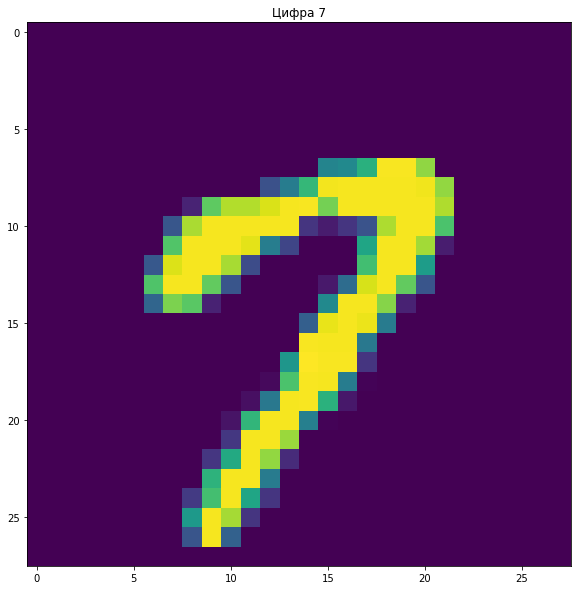

In [45]:
plt.figure(figsize=(10, 10))
plt.title(f'Цифра {mnist_train[15][1]}')
plt.imshow(mnist_train[15][0][0])

plt.show()

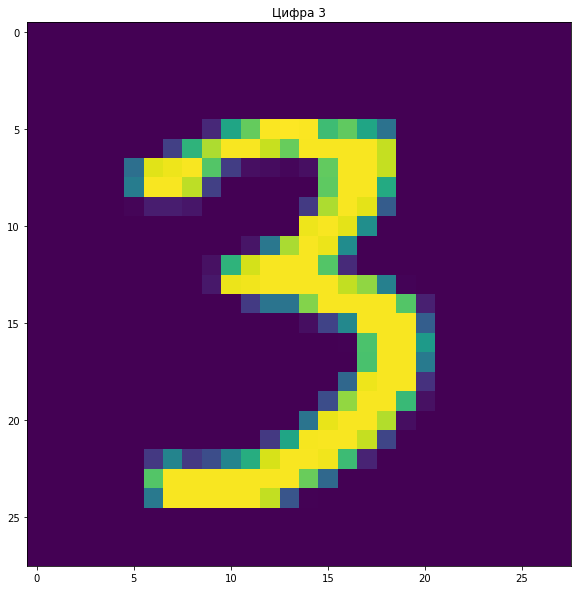

In [46]:
plt.figure(figsize=(10, 10))
plt.title(f'Цифра {mnist_train[10000][1]}')
plt.imshow(mnist_train[10000][0][0])

plt.show()

## Полносвязная нейронная сеть

Обучим полносвязную нейронную сеть на датасете MNIST.

In [47]:
import torch.nn as nn
from torch.utils.data import DataLoader
from torch.optim import Optimizer


def train(model: nn.Module, data_loader: DataLoader, optimizer: Optimizer, loss_fn):
    model.train()

    total_loss = 0
    total_correct = 0

    for x, y in tqdm(data_loader):
        optimizer.zero_grad()

        output = model(x)

        loss = loss_fn(output, y)

        loss.backward()

        total_loss += loss.item()
        
        total_correct += (output.argmax(dim=1) == y).sum().item()

        optimizer.step()

    return total_loss / len(data_loader), total_correct / len(data_loader.dataset)


In [48]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader


@torch.inference_mode()
def evaluate(model: nn.Module, data_loader: DataLoader, loss_fn):
    model.eval()

    total_loss = 0
    total_correct = 0

    for x, y in tqdm(data_loader):
        output = model(x)

        loss = loss_fn(output, y)

        total_loss += loss.item()

        total_correct += (output.argmax(dim=1) == y).sum().item()

    return total_loss / len(data_loader), total_correct / len(data_loader.dataset)


In [49]:
import matplotlib.pyplot as plt
import seaborn as sns


sns.set(style='darkgrid')


def plot_stats(
    train_loss: list[float],
    valid_loss: list[float],
    train_accuracy: list[float],
    valid_accuracy: list[float],
    title: str
):
    plt.figure(figsize=(16, 8))

    plt.title(title + ' loss')

    plt.plot(train_loss, label='Train loss')
    plt.plot(valid_loss, label='Valid loss')
    plt.legend()

    plt.show()
    
    plt.figure(figsize=(16, 8))

    plt.title(title + ' accuracy')

    plt.plot(train_accuracy, label='Train accuracy')
    plt.plot(valid_accuracy, label='Valid accuracy')
    plt.legend()

    plt.show()

In [50]:
from IPython.display import clear_output


def fit(model, train_loader, valid_loader, optimizer, loss_fn, num_epochs, title):
    train_loss_history, valid_loss_history = [], []
    train_accuracy_history, valid_accuracy_history = [], []

    for epoch in range(num_epochs):
        train_loss, train_accuracy = train(model, train_loader, optimizer, loss_fn)
        valid_loss, valid_accuracy = evaluate(model, valid_loader, loss_fn)

        train_loss_history.append(train_loss)
        valid_loss_history.append(valid_loss)
        
        train_accuracy_history.append(train_accuracy)
        valid_accuracy_history.append(valid_accuracy)

        clear_output()

        plot_stats(
            train_loss_history, valid_loss_history,
            train_accuracy_history, valid_accuracy_history,
            title
        )

In [51]:
first_model = nn.Sequential(
    nn.Flatten(),
    nn.Linear(28 * 28, 256),
    nn.ReLU(),
    nn.Linear(256, 10)
)

optimizer = torch.optim.Adam(first_model.parameters(), lr=1e-3)

loss_fn = nn.CrossEntropyLoss()

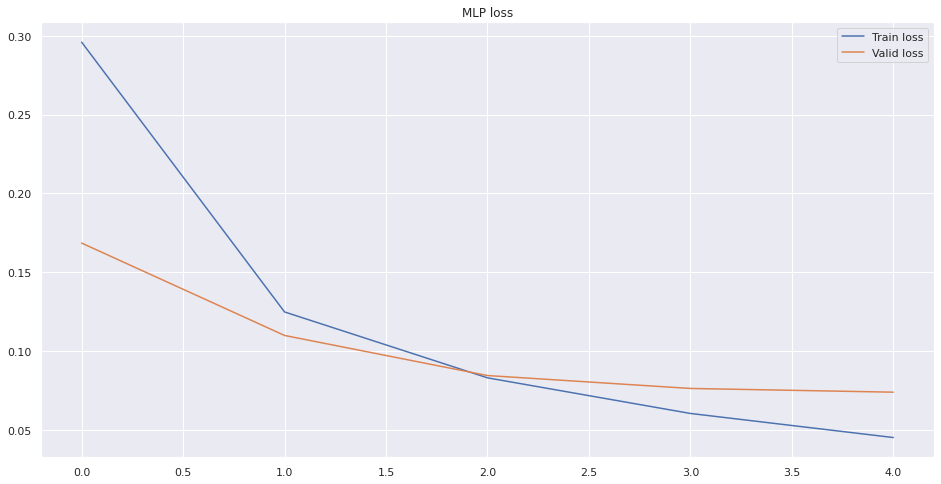

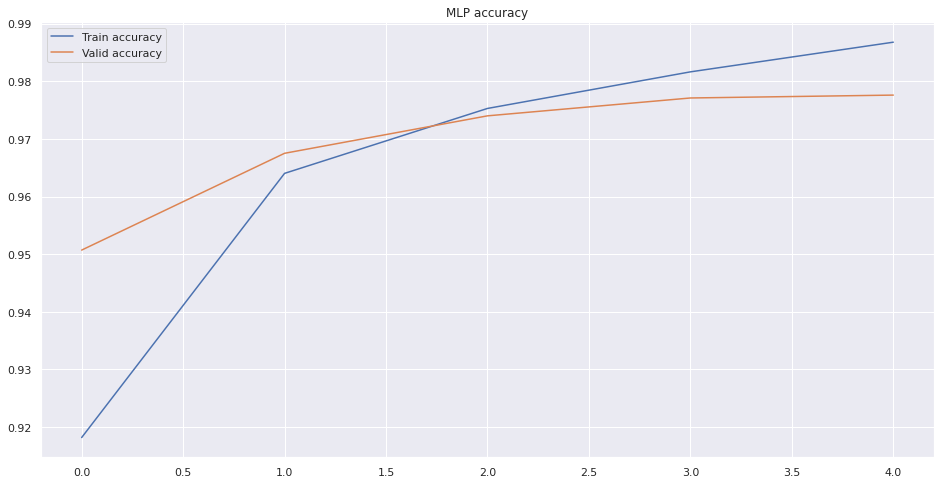

  5%|██▋                                                 | 8/157 [00:00<00:00, 257.70it/s]


KeyboardInterrupt: 

In [52]:
fit(first_model, train_loader, valid_loader, optimizer, loss_fn, 15, 'MLP')

## Сверточная сеть

In [53]:
second_model = nn.Sequential(
    nn.Conv2d(in_channels=1, out_channels=16, kernel_size=5),  # 28 x 28 -> 24 x 24
    nn.LeakyReLU(),
    nn.MaxPool2d(kernel_size=2),  # 24 x 24 -> 12 x 12

    nn.Conv2d(in_channels=16, out_channels=16, kernel_size=5),  # 12 x 12 -> 8 x 8
    nn.LeakyReLU(),
    nn.MaxPool2d(kernel_size=2),  # 8 x 8 -> 4 x 4

    nn.Flatten(),  # 4 x 4 x 16 -> 4 * 4 * 16
    nn.Linear(4 * 4 * 16, 256),
    nn.LeakyReLU(),
    nn.Linear(256, 10)
)

optimizer = torch.optim.Adam(second_model.parameters(), lr=1e-3)

loss_fn = nn.CrossEntropyLoss()

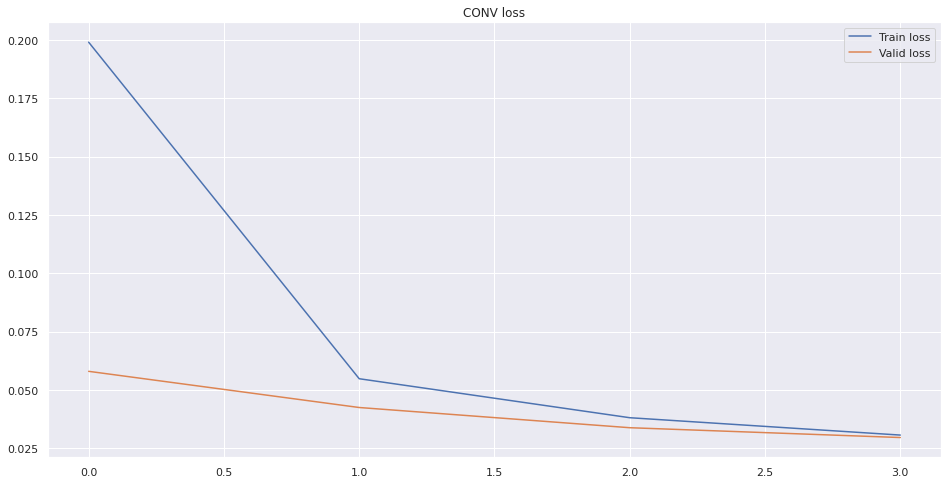

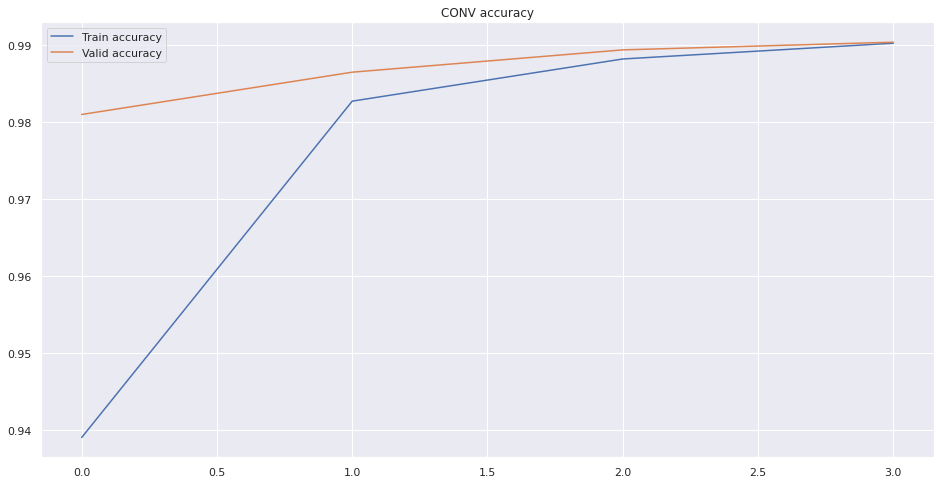

  5%|██▎                                                | 43/938 [00:00<00:05, 159.22it/s]


KeyboardInterrupt: 

In [54]:
fit(second_model, train_loader, valid_loader, optimizer, loss_fn, 15, 'CONV')